In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'},
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import pandas as pd
import seaborn as sns 
import codecs, json
from scipy.optimize import minpack2

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.0.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between 1 and -1 [256x1]

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

a_1 = 1 
a_2 = 4

usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y) #solution chosen for convinience  

u = usol.flatten('F')[:,None] 

# Training Data

In [4]:
def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train 


# PINN 

$W \in \mathcal{R}^{n_{l-1}\times{n_l}}$ 

Creating sequential layers using the $\textit{class}$ tf.Module

In [5]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):

        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters

        for i in range(len(layers)-1):

            input_dim = layers[i]
            output_dim = layers[i+1]

            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv

            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))

            self.W.append(w)
            self.W.append(b)

            self.parameters +=  input_dim * output_dim + output_dim
            
        self.X = np.zeros(self.parameters) #store iterates
        self.G = np.zeros(self.parameters) #store gradients
        self.store = np.zeros((max_iter,2)) #store computed values for plotting
        self.iter_counter = 0 # iteration counter for optimizer
    
    def evaluate(self,x):
        
        #preprocessing input 
        x = (x - lb)/(ub - lb) #feature scaling
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)

        k = 1    

        x_1_f = g[:,0:1]
        x_2_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_1_f)
            tape.watch(x_2_f)

            g = tf.stack([x_1_f[:,0], x_2_f[:,0]], axis=1)

            u = self.evaluate(g)
            u_x_1 = tape.gradient(u,x_1_f)
            u_x_2 = tape.gradient(u,x_2_f)

        u_xx_1 = tape.gradient(u_x_1,x_1_f)
        u_xx_2 = tape.gradient(u_x_2,x_2_f)

        del tape

        q = -( (a_1*np.pi)**2 + (a_2*np.pi)**2 - k**2 ) * np.sin(a_1*np.pi*x_1_f) * np.sin(a_2*np.pi*x_2_f)

        f = u_xx_1 + u_xx_2 + k**2 * u - q #residual

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f, f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f, f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f 
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #store 1d grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases
        
        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
                
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        alpha, f_newval = self.LbfgsInvHessProduct(parameters)
        
        tf.print(loss_value, f_newval, loss_value-f_newval, alpha)
        
    def LbfgsInvHessProduct(self,parameters):

        self.iter_counter += 1  #update iteration counter 

        x_k = parameters  

        self.X = np.vstack((x_k.T,self.X)) #stack latest value on top row

        old_fval,g_k = self.optimizerfunc(x_k) #obtain grads and loss value

        self.G = np.vstack((g_k.T,self.G)) #stack latest grads on top row

        n_corrs = min(self.iter_counter, maxcor) #for iterations < maxcor, we will take all available updates
        
        sk = self.X = self.X[:n_corrs] #select top 'n_corrs' x values, with latest value on top by construction
        yk = self.G = self.G[:n_corrs] #select top 'n_corrs' gradient values, with latest value on top by construction 

        #linear operator B_k_inv    
        hess_inv = scipy.optimize.LbfgsInvHessProduct(sk,yk) #instantiate class

        p_k = - hess_inv.matvec(g_k) #p_k = -B_k_inv * g_k

        gkpk = np.dot(p_k,g_k) #term 1 in report

        norm_p_k_sq = (np.linalg.norm(p_k,ord=2))**2 # norm squared
               
        #store the values
        self.store[self.iter_counter-1] = [gkpk,norm_p_k_sq]
        
        def line_search_armijo(f, xk, pk, gfk, old_fval, args=(), c1=1e-4, alpha0=1):
            """Minimize over alpha, the function ``f(xk+alpha pk)``.
            Parameters
            ----------
            f : callable
                Function to be minimized.
            xk : array_like
                Current point.
            pk : array_like
                Search direction.
            gfk : array_like
                Gradient of `f` at point `xk`.
            old_fval : float
                Value of `f` at point `xk`.
            args : tuple, optional
                Optional arguments.
            c1 : float, optional
                Value to control stopping criterion.
            alpha0 : scalar, optional
                Value of `alpha` at start of the optimization.
            Returns
            -------
            alpha
            f_count
            f_val_at_alpha
            Notes
            -----
            Uses the interpolation algorithm (Armijo backtracking) as suggested by
            Wright and Nocedal in 'Numerical Optimization', 1999, pp. 56-57
            """
            xk = np.atleast_1d(xk)
            fc = [0]

            def phi(alpha1):
                fc[0] += 1
                return f(xk + alpha1*pk, *args)

            if old_fval is None:
                phi0 = phi(0.)
            else:
                phi0 = old_fval  # compute f(xk) -- done in past loop

            derphi0 = np.dot(gfk, pk)
            alpha, phi1 = scalar_search_armijo(phi, phi0, derphi0, c1=c1,
                                               alpha0=alpha0)
            return alpha, fc[0], phi1


        def line_search_BFGS(f, xk, pk, gfk, old_fval, args=(), c1=1e-4, alpha0=1):
            """
            Compatibility wrapper for `line_search_armijo`
            """
            r = line_search_armijo(f, xk, pk, gfk, old_fval, args=args, c1=c1,
                                   alpha0=alpha0)
            return r[0], r[1], 0, r[2]


        def scalar_search_armijo(phi, phi0, derphi0, c1=1e-4, alpha0=1, amin=0):
            """Minimize over alpha, the function ``phi(alpha)``.
            Uses the interpolation algorithm (Armijo backtracking) as suggested by
            Wright and Nocedal in 'Numerical Optimization', 1999, pp. 56-57
            alpha > 0 is assumed to be a descent direction.
            Returns
            -------
            alpha
            phi1
            """
            phi_a0 = phi(alpha0)
            if (phi_a0 <=  phi0 + c1*alpha0*derphi0):
                return alpha0, phi_a0

            # Otherwise, compute the minimizer of a quadratic interpolant:

            alpha1 = -(derphi0) * alpha0**2 / 2.0 / (phi_a0 - phi0 - derphi0 * alpha0)
            phi_a1 = phi(alpha1)

            if (phi_a1 <= phi0 + c1*alpha1*derphi0):
                return alpha1, phi_a1

            # Otherwise, loop with cubic interpolation until we find an alpha which
            # satisfies the first Wolfe condition (since we are backtracking, we will
            # assume that the value of alpha is not too small and satisfies the second
            # condition.

            while alpha1 > amin:       # we are assuming alpha>0 is a descent direction
                factor = alpha0**2 * alpha1**2 * (alpha1-alpha0)
                a = alpha0**2 * (phi_a1 - phi0 - derphi0*alpha1) - \
                    alpha1**2 * (phi_a0 - phi0 - derphi0*alpha0)
                a = a / factor
                b = -alpha0**3 * (phi_a1 - phi0 - derphi0*alpha1) + \
                    alpha1**3 * (phi_a0 - phi0 - derphi0*alpha0)
                b = b / factor

                alpha2 = (-b + np.sqrt(abs(b**2 - 3 * a * derphi0))) / (3.0*a)
                phi_a2 = phi(alpha2)

                if (phi_a2 <= phi0 + c1*alpha2*derphi0):
                    return alpha2, phi_a2

                if (alpha1 - alpha2) > alpha1 / 2.0 or (1 - alpha2/alpha1) < 0.96:
                    alpha2 = alpha1 / 2.0

                alpha0 = alpha1
                alpha1 = alpha2
                phi_a0 = phi_a1
                phi_a1 = phi_a2

            # Failed to find a suitable step length
            return None, phi_a1
        
        #compatibility wrapper
        def ls_function(x):
            val, _ = self.optimizerfunc(x)
            return val
        
        alpha, _, _, f_newval = line_search_BFGS(ls_function, x_k, p_k, g_k, old_fval, args=(), c1=1e-4, alpha0=1)    
        
        return alpha, f_newval
        

# *Loss Function*

The loss function consists of two parts:
1. **loss_BC**: MSE error of boundary losses
2. **loss_PDE**: MSE error of collocation points satisfying the PDE

**loss** = loss_BC + loss_PDE

In [48]:
N_u = 400 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2, 50, 50, 50, 1]) #3 hidden layers

maxcor = 200 
max_iter = 5000

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': maxcor, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-10, 
                                            'maxfun':  max_iter*1.5, 
                                            'maxiter': max_iter,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

# np.savetxt('values_stiff.txt', PINN.store)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,256),order='F') 

# #Plot and save image
# plt.pcolor(x_1,x_2,u_pred, cmap = 'jet')
# plt.axis('scaled')
# plt.colorbar()
# plt.savefig('Stiff_Helmholtz.png', dpi = 500)

# #Error plot
# plt.pcolor(x_1,x_2,np.abs(usol-u_pred), cmap = 'jet')
# plt.axis('scaled')
# plt.colorbar()
# plt.savefig('Stiff_Helmholtz_error.png', dpi = 500)
# plt.close()

# #Residual plot
# loss_f, f_plot = PINN.loss_PDE(X_u_test)
# plt.scatter(X_u_test[:,0:1], X_u_test[:,1:2], c=f_plot, cmap = 'jet')
# plt.axis('scaled')
# plt.colorbar()
# plt.savefig('Stiff_Helmholtz_residual.png', dpi = 500)

# #plot gkpk
# plt.semilogy(PINN.store[:,0])
# plt.yscale('symlog')
# plt.savefig('gkpk_stiff.png', dpi = 500)

# #plot norm_p_k_sq
# plt.semilogy(PINN.store[:,1])
# plt.yscale('symlog')
# plt.savefig('norm_p_k_sq_stiff.png', dpi = 500)

84.518615140963334 84.51860409376859 1.104719474653848e-05 -0.0003633599705001406
84.516940601758861 84.51694059982557 1.9332873080202262e-09 -6.861359537960459e-08
84.504280733142167 84.50425952630324 2.1206838923149007e-05 5.939705230099322e-05
84.49745397934096 84.49745274618297 1.233157988167477e-06 2.047540826070801e-06
Training time: 12.54
      fun: 84.49745397934096
 hess_inv: <5301x5301 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00432124, -0.00888981,  0.00670883, ..., -0.01213488,
       -0.00457839, -0.08033026])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 6
      nit: 4
     njev: 6
   status: 1
  success: False
        x: array([ 0.13373143,  0.01946636, -0.09126716, ...,  0.11480737,
        0.24000531, -0.0376938 ])
Test Error: 1.02613


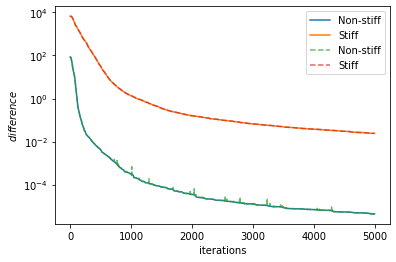

In [20]:
#plot loss and loss_predicted
fig,ax = plt.subplots()
plt.semilogy(s1[:,0], label = 'Non-stiff', alpha = 1)
plt.semilogy(s2[:,0], label = 'Stiff', alpha = 1)
plt.semilogy(s1[:,1], '--', label = 'Non-stiff', alpha = 0.7)
plt.semilogy(s2[:,1], '--', label = 'Stiff', alpha = 0.7)
# plt.scatter(np.arange(5000), s2[:,3], label = 'Stiff')
plt.xlabel('iterations')
plt.ylabel('$difference$')
plt.legend()
plt.show()
fig.savefig('difference_loss_vs_predicted_loss.png', dpi=500)

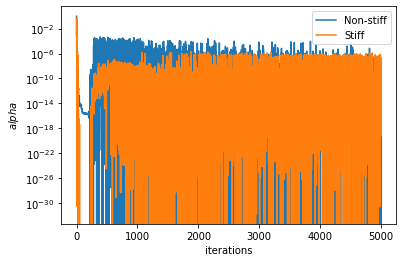

In [18]:
#plot step size
fig,ax = plt.subplots()
plt.semilogy(s1[:,3], label = 'Non-stiff', alpha = 1)
plt.semilogy(s2[:,3], label = 'Stiff', alpha = 1)
# plt.scatter(np.arange(5000), s2[:,3], label = 'Stiff')
plt.xlabel('iterations')
plt.ylabel('$alpha$')
plt.legend()
plt.show()